## Decoding Heatmaps using LLMs
In this notebook, we evaluate the performance of LLMs to describe and analyse LRP heatmaps.
Goal is to compare the LLM's results of choosing the most highlighted regions in the LRP heatmaps to the results from regional analysis using mediapipe.

In [ ]:
from openai import OpenAI
import os
from facesim3d import local_paths

In [ ]:
my_api_key = "your-api-key-goes-here"

In [4]:
# OpenAI client
client = OpenAI(base_url="https://llm.scads.ai/v1", api_key=my_api_key)

In [5]:
for m in client.models.list().data:
    if "Qwen/Qwen2" in m.id:
        llm_model_name = m.id
        print(llm_model_name)
        break

Qwen/Qwen2-VL-7B-Instruct


In [6]:
REGIONS = [
    "mouth", "nose_tip", "nose_bridge", "left_eye", "right_eye",
    "left_eyebrow", "right_eyebrow", "forehead", "left_cheek",
    "right_cheek", "chin", "space between eyes"
]

system_prompt = "You are a skilled AI assistant that is asked to participate in a study about face similarity."

final_prompt = (
    "These are LRP heatmaps of a face-triplet."
    "The color of each pixel is the corresponding relevance score from LRP."
    "The darker the red, the more relevant the pixel"
    "The darker the blue, the LESS relevant the pixel"
    "Your task is to decide which regions show the HIGHEST amount of relevance."
    "This means, you are looking for the DARKEST RED colored pixels and regions."
    f"Here are the ONLY possible facial regions you can choose from: {', '.join(REGIONS)}."
    "Your answer must be a valid python list like this:\n"
    "['region x', 'region y', 'region z']"
    "Regions should be a list of UP TO 3 chosen facial regions from the provided list."
    "If you think one region is most prominent in the heatmap, just name one."
    "If two regions are most prominent, choose two."
    "If more than two regions are prominent, choose the THREE most important ones in the current heatmap."
)

### Building the Pipeline

In [ ]:
import base64
import glob

def encode_image(path):
    with open(path, "rb") as f:
        return base64.b64encode(f.read()).decode("utf-8")

heatmap_folder = local_paths.DIR_AVERAGE_HEATMAPS_HUM

paths = sorted(glob.glob(os.path.join(heatmap_folder, f"head_*.png")))
heatmaps = []

for p in paths:
    heatmaps.append(encode_image(p))

print(f"Loaded {len(heatmaps)} heatmaps.")

Loaded 100 heatmaps.


In [15]:
import ast
from tqdm import tqdm 

responses = []

for image in tqdm(heatmaps, desc="Processing images"):
    message = [
        {"role": "system", "content": system_prompt},
        {
            "role": "user",
            "content": [
                {"type": "text", "text": final_prompt},
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/png;base64,{image}"}
                },
            ],
        },
    ]

    response = client.chat.completions.create(model=llm_model_name, messages=message)
    raw = response.choices[0].message.content.strip()
    try:
        parsed = ast.literal_eval(raw)
        responses.append(parsed)
    except Exception as e:
        print("Parsing error:", raw, "| error:", e)
        continue

Processing images: 100%|██████████| 100/100 [00:27<00:00,  3.70it/s]


## Load the Mediapipe heatmap analysis results

In [ ]:
import pandas as pd

csv_folder = local_paths.DIR_REGION_ANALYSIS_RESULTS
csv_file = os.path.join(csv_folder,"relevance_per_region_dataset_hj.csv")

df = pd.read_csv(csv_file)
region_cols = [c for c in df.columns if c != "image_name"]
df = df[region_cols]

all_regions = df.columns.tolist()
df.head()

,mouth,nose_tip,nose_bridge,left_eye,space between eyes,forehead,chin,left_cheek,left_eyebrow,right_eye,right_cheek,right_eyebrow
0,0.000315,0.000310,0.000248,0.000194,0.000405,-0.000040,0.000056,0.000066,0.000046,0.000203,0.000084,0.000183
1,-0.001399,-0.002213,-0.000527,-0.001067,-0.002133,-0.000003,-0.000394,-0.000444,-0.000756,-0.000911,-0.000559,-0.000660
2,-0.000035,0.000232,0.000118,0.000249,0.001035,0.000008,-0.000009,0.000045,0.000177,0.000156,0.000045,0.000182
3,0.000170,0.000165,-0.000014,-0.000009,-0.000092,-0.000046,0.000303,0.000027,-0.000012,-0.000054,0.000022,-0.000060
4,0.000503,0.000636,0.000484,0.000481,0.000413,-0.000014,0.000207,0.000144,0.000367,0.001012,0.000160,0.000758


In [10]:
# get regions with highest relevance scores
top3_from_df = df.apply(lambda row: row.nlargest(3).index.tolist(), axis=1)

In [16]:
# print out the comparison
for i in range(len(responses)):
    pred = set(responses[i])
    true = set(top3_from_df.iloc[i])
    
    overlap = pred.intersection(true)
    num_matches = len(overlap)
    
    print(f"--- Row {i} ---")
    print(f"Predicted: {responses[i]}")
    print(f"True top-3: {top3_from_df.iloc[i]}")
    print(f"Matches ({num_matches}/3): {sorted(list(overlap))}")
    print()

--- Row 0 ---
Predicted: ['nose_bridge', 'left_cheek', 'right_cheek']
True top-3: ['space between eyes', 'mouth', 'nose_tip']
Matches (0/3): []

--- Row 1 ---
Predicted: ['nose_bridge', 'left_cheek', 'right_cheek']
True top-3: ['forehead', 'chin', 'left_cheek']
Matches (1/3): ['left_cheek']

--- Row 2 ---
Predicted: ['mouth', 'nose_tip', 'nose_bridge']
True top-3: ['space between eyes', 'left_eye', 'nose_tip']
Matches (1/3): ['nose_tip']

--- Row 3 ---
Predicted: ['nose_bridge', 'left_cheek', 'right_cheek']
True top-3: ['chin', 'mouth', 'nose_tip']
Matches (0/3): []

--- Row 4 ---
Predicted: ['left_eye', 'right_eye', 'nose_bridge']
True top-3: ['right_eye', 'right_eyebrow', 'nose_tip']
Matches (1/3): ['right_eye']

--- Row 5 ---
Predicted: ['nose_bridge', 'left_cheek', 'right_cheek']
True top-3: ['right_cheek', 'chin', 'forehead']
Matches (1/3): ['right_cheek']

--- Row 6 ---
Predicted: ['nose_bridge', 'left_cheek', 'right_cheek']
True top-3: ['space between eyes', 'nose_tip', 'left_ey

In [17]:
# compute a list of match counts
match_counts = []  # stores values 0, 1, 2, or 3

for i in range(len(responses)):
    pred = set(responses[i])
    true = set(top3_from_df.iloc[i])
    
    overlap = len(pred.intersection(true))
    match_counts.append(overlap)

### Visualize

Counter({0: 68, 1: 29, 2: 3})


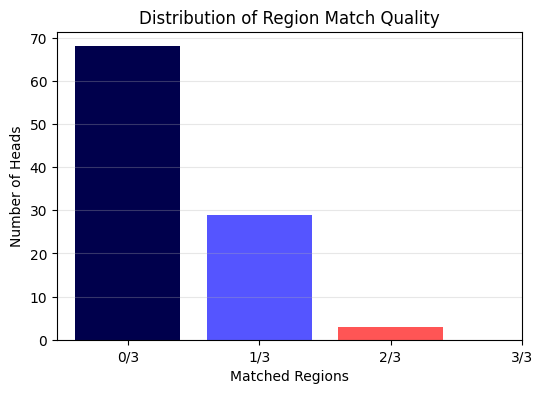

In [18]:
import matplotlib.pyplot as plt
import collections

summary = collections.Counter(match_counts)
print(summary)

plt.figure(figsize=(6,4))
plt.bar(summary.keys(), summary.values(), color=["#00004c","#5555ff","#ff5555","green"])
plt.xticks([0,1,2,3], ["0/3","1/3","2/3","3/3"])
plt.ylabel("Number of Heads")
plt.xlabel("Matched Regions")
plt.title("Distribution of Region Match Quality")
plt.grid(axis="y", alpha=0.3)
plt.savefig("distribution_of_match_counts_v3_HJ.png")
plt.show()

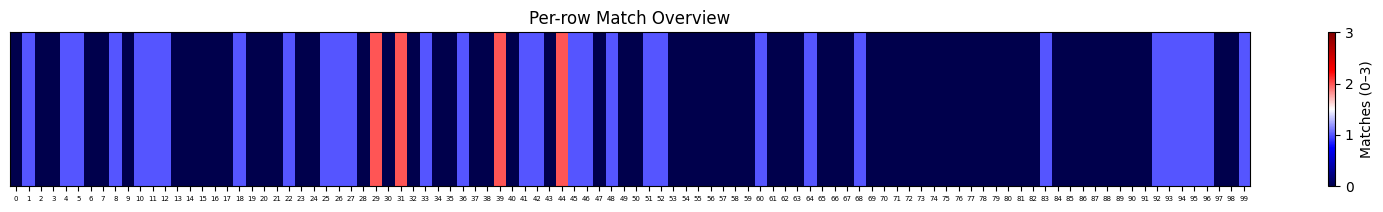

In [31]:
import numpy as np

plt.figure(figsize=(20,2))
plt.imshow(np.array([match_counts]), aspect="auto",
           cmap="seismic", vmin=0, vmax=3)
plt.xticks(range(len(match_counts)), range(len(match_counts)), fontsize=5)
plt.yticks([])
plt.colorbar(label="Matches (0–3)")
plt.title("Per-row Match Overview")
plt.savefig("per_row_match_overview_HJ.png")
plt.show()

In [23]:
from collections import Counter

# count the ground truth counts for each region
llm_region_counter = Counter()

for lst in responses:
    for region in lst:
        llm_region_counter[region] += 1

llm_counts = {region: llm_region_counter.get(region, 0) for region in all_regions}

In [21]:
# count the ground truth counts for each region
true_region_counter = Counter()

for lst in top3_from_df.tolist():
    for region in lst:
        true_region_counter[region] += 1

true_counts = {region: true_region_counter.get(region, 0) for region in all_regions}

In [24]:
# 1. Sort all region names alphabetically
sorted_regions = sorted(all_regions)

# 2. Reorder true_counts and llm_counts according to sorted_regions
true_vals = [true_counts[r] for r in sorted_regions]
llm_vals  = [llm_counts[r]  for r in sorted_regions]

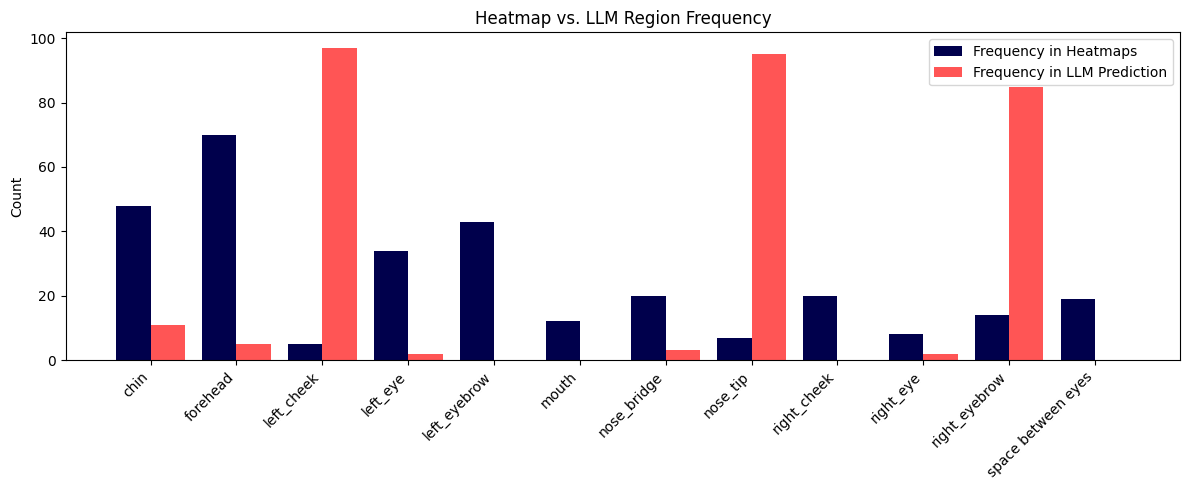

In [26]:
import numpy as np

x = np.arange(len(all_regions))      # positions
width = 0.4                      # bar width

fig, ax = plt.subplots(figsize=(12, 5))

ax.bar(x - width/2, true_counts.values(), width, label="Frequency in Heatmaps", color="#00004c")
ax.bar(x + width/2, llm_counts.values(), width, label="Frequency in LLM Prediction", color="#ff5555" )

ax.set_xticks(x)
ax.set_xticklabels(sorted_regions, rotation=45, ha="right")
ax.set_ylabel("Count")
ax.set_title("Heatmap vs. LLM Region Frequency")
ax.legend()
plt.tight_layout()
plt.savefig("heatmap_VS_llm_regions_HJ.png")
plt.show()